# BE Anomaly Detection
#### Michta Louvet Blanc

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
%matplotlib inline

### Part 1: Data observation and preparation

In [92]:
df = pd.read_csv("dataset.csv")
df.describe()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
count,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000
mean,0.000009,0.000011,0.000031,0.000005,0.000016,-0.000005,-0.000002,0.000003,-0.000021,0.000026,0.000030
std,0.999950,0.999925,0.999961,0.999925,0.999963,0.999926,0.999950,0.999949,0.997770,0.999686,0.999847
min,-3.211980,-3.395387,-3.325651,-3.378450,-3.281286,-4.200181,-3.898025,-3.524957,-13.704556,-12.044778,-3.183571
25%,-0.678808,-0.482716,-0.629123,-0.491585,-0.612334,-0.559023,-0.606135,-0.736398,-0.593096,-0.498480,-0.658530
50%,0.041883,0.180360,0.041442,0.147397,0.117040,0.153972,0.186038,-0.012354,-0.034882,-0.257635,-0.015437
75%,0.743973,0.656920,0.659246,0.636887,0.712393,0.685353,0.718237,0.802395,0.508232,0.359773,0.636740
max,5.013899,6.260782,8.652950,8.359670,6.424227,5.638259,3.735957,4.667058,8.203706,5.597387,9.204384


In [93]:
#sns_plot = sns.pairplot(df[:8000],hue='day_cycle_window',  height=2.5);
#sns_plot.savefig("repartitions.png")

In [94]:
day_cycle_window = df['day_cycle_window']
df = df.drop(['day_cycle_window'], axis=1)
print('les distributions sont centrées et réduites: \n')
print('mean: \n',df.mean(), '\n')
print('std: \n',df.std())

les distributions sont centrées et réduites: 

mean: 
 p1     0.000009
p2     0.000011
p3     0.000031
p4     0.000005
p5     0.000016
p6    -0.000005
p7    -0.000002
p8     0.000003
p9    -0.000021
p10    0.000026
p11    0.000030
dtype: float64 

std: 
 p1     0.999950
p2     0.999925
p3     0.999961
p4     0.999925
p5     0.999963
p6     0.999926
p7     0.999950
p8     0.999949
p9     0.997770
p10    0.999686
p11    0.999847
dtype: float64



 Certains points sont éloignés d une distribution normale des données: 



/Users/axel/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


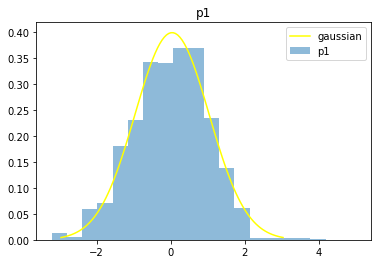

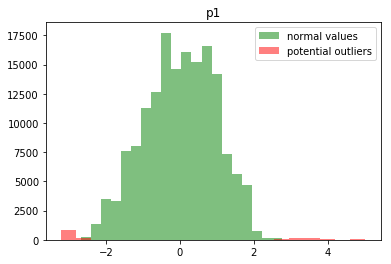

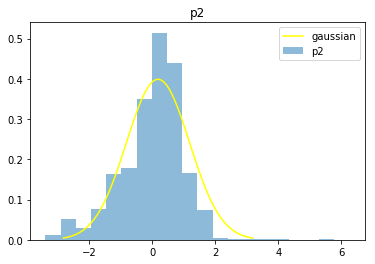

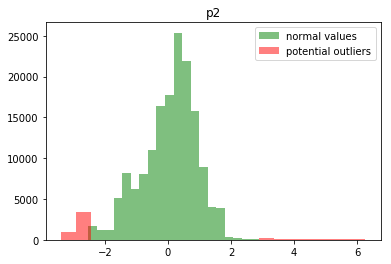

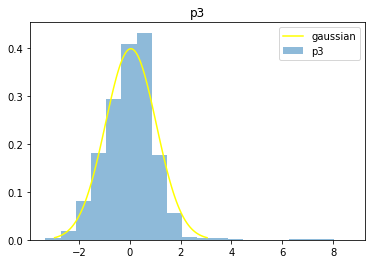

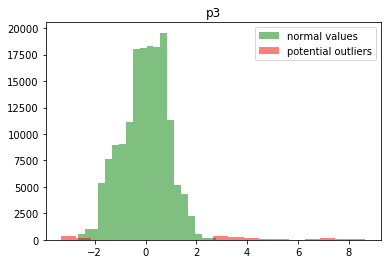

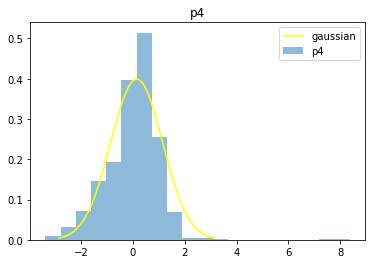

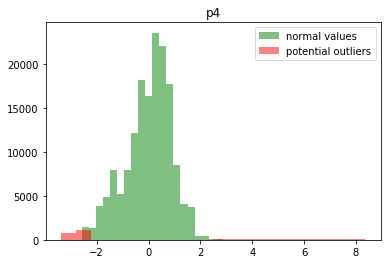

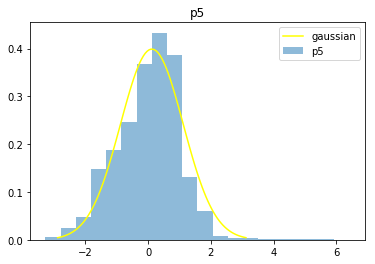

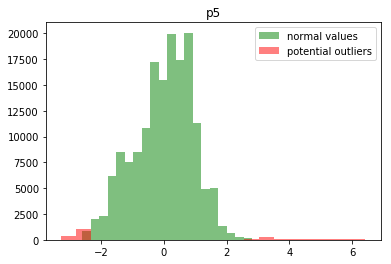

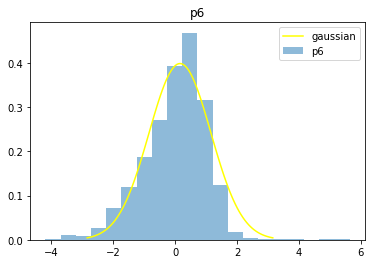

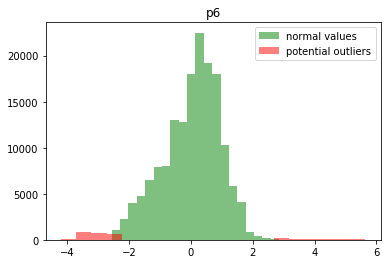

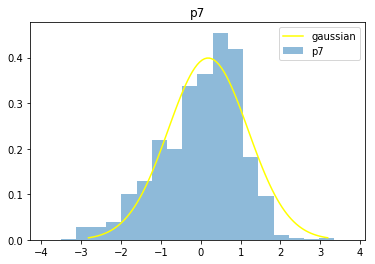

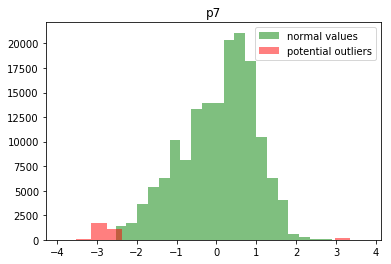

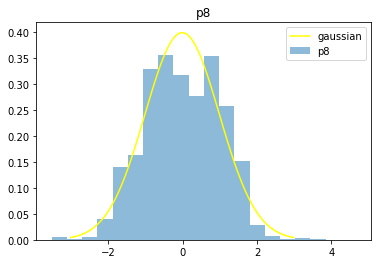

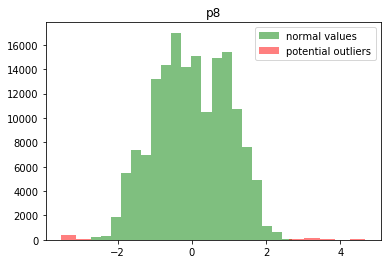

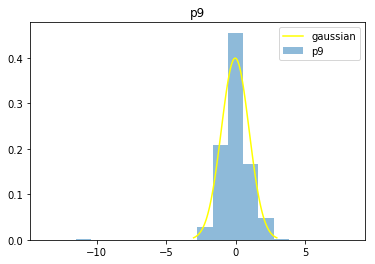

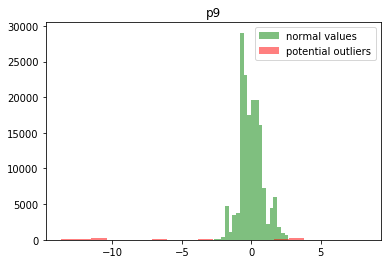

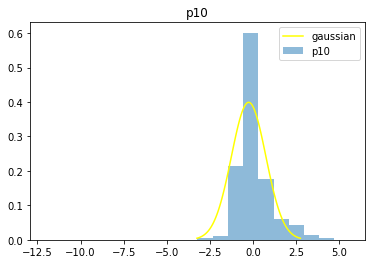

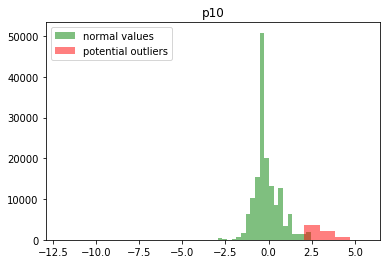

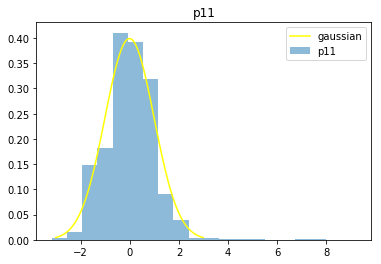

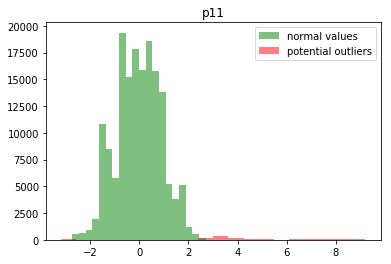

In [52]:
print('\n Certains points sont éloignés d une distribution normale des données: \n')
for col in df.columns.unique():
    m = df[col].median()
    s = df[col].std()
    x = np.linspace(m - 3*s, m + 3*s, 100)
    gaussian = stats.norm.pdf(x, m, s)

    ins = df[stats.norm.pdf(df[col], m, s)>0.01];
    outs = df[stats.norm.pdf(df[col], m, s)<0.01];

    plt.figure()
    l = plt.hist(df[col], density=True, bins = 20, alpha=0.5, label = col)
    plt.plot(x, gaussian, color = 'yellow', label = 'gaussian')
    plt.legend()
    plt.title(col)

    plt.figure()
    plt.hist(df[col],density=True, alpha=0.5)
    plt.hist(ins[col],  alpha=0.5,color='green',bins=20,label='normal values')
    plt.hist(outs[col], alpha=0.5, color='red', bins=20, label='potential outliers')
    plt.legend()
    plt.title(col)
    

## Part 2: Prediction

Nous allons ici essayer de détecter les points qui sont des outliers. Les windows qui contiennent le plus grand nombre de tels points seront alors considérées comme outliers.



On choisit ici:
- Contamination = 15%, ce qui ne signifie que nos classifiers cherchent 15% d'outliers. Cependant, comme nous allons utiliser ces résultats pour détecter les windows outliser, cela ne signifie pas qu'il y aura 15% de windows outliers


Et comme classifiers: 
- Elliptic Enveloppe, qui nous permettra d'éloigner les valeurs s'éloignant d'une répartition gaussienne des données
- Isolation Forest, pour éviter le swamping et le masking
- LOF, qui nous permettra aussi de trouver de trouver les points proches de clusters denses (locality aspect)

In [53]:
def plotAnomalyScore2D_bis(df, clf_name, clf, f1,f2):
    """
        Same as plotAnomalyScore2D, but with a classifier trained on the whole dataset
        - df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        - clf_name: String value - name of the outlier detection model
        - clf: Scikit Learn model instance - the trained outlier detection model
    """
    if clf_name == 'LOF':
        score = clf.negative_outlier_factor_
    else:
        score = clf.decision_function(df)
    
    plt.figure()
    sc = plt.scatter(x=df[f1],y=df[f2], c=-score, cmap='Reds')
    plt.colorbar(sc, label='anomaly score')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(clf_name)

In [54]:
isf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.15)
isf.fit(df)

lof = LocalOutlierFactor(n_neighbors=5, contamination=0.15, novelty = True)
lof.fit(df)

cov = EllipticEnvelope(random_state=0)
cov.fit(df)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=0,
         store_precision=True, support_fraction=None)

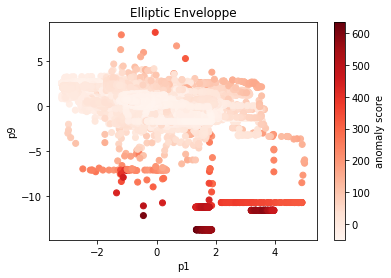

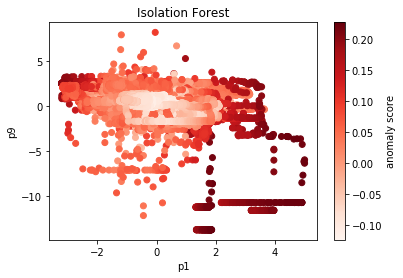

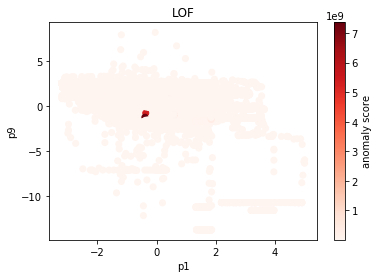

In [55]:
plotAnomalyScore2D_bis(df, 'Elliptic Enveloppe', cov, 'p1','p9')
plotAnomalyScore2D_bis(df, 'Isolation Forest', isf, 'p1','p9')
plotAnomalyScore2D_bis(df, 'LOF', lof, 'p1','p9')

#### Vision 1:

Si l'on souhaite considérer les scores de ces trois types d'anomalies, et créer un nouveau score en les combinant. Ici, un point est une anomalie si un des classifiers est très confiants, ou si plusieurs sont légèrements confiants. Certains points peuvent cependant être éliminés des outliers par effet de swamping ou masking

In [56]:
lof_score = lof.negative_outlier_factor_
isf_score = isf.decision_function(df)
cov_score = cov.decision_function(df)

In [57]:
print(lof_score)
print(isf_score)
print(cov_score)

[-0.96752156 -0.96752156 -0.99444759 ... -0.98086946 -1.43916958
 -3.37578775]
[0.02019832 0.02171602 0.02180055 ... 0.07750874 0.07944444 0.07614862]
[27.30509486 25.9325492  24.44174406 ... 38.00804851 38.29318691
 38.37519321]


In [58]:
print(lof_score.mean())
print(lof_score.std())
print(np.median(lof_score))
print('\n\n')
print(isf_score.mean())
print(isf_score.std())
print(np.median(isf_score))
print('\n\n')
print(cov_score.mean())
print(cov_score.std())
print(np.median(cov_score))

-1530125.0452684928
32211310.41526891
-1.0129270821342191



0.054533418292653776
0.051876489200430705
0.0682921437392123



28.227682699267334
33.35704049092154
36.51979643443042


In [89]:
#NORMALISER LES SCORES: VOIR DOC POUR SAVOIR A QUOI ILS CORRESPONDENT

In [59]:
anomaly_score = lof_score+isf_score+cov_score

#### Vision 2:

Si l'on considère qu'un point est une potentielle anomalie dès qu'un des classifiers l'a détecté comme tel, et que l'on souhaite sommer ces anomalies par windows:

In [95]:
anomaly_lof = lof.predict(df)
anomaly_cov = cov.predict(df)
anomaly_isf = isf.predict(df)
anomaly = (anomaly_lof+anomaly_cov+anomaly_isf == -1).astype(int)

In [147]:
df2 = df.copy()
df2['window']=day_cycle_window 
df2['anomaly']=anomaly
outliers_per_column = df2.groupby('window')['anomaly'].sum().sort_values(ascending = False)
outliers_per_column[:8]

window
2_3_4     99
3_1_12    98
3_1_1     98
4_2_1     98
4_3_22    97
4_3_64    97
1_2_8     96
3_1_3     96
Name: anomaly, dtype: int64

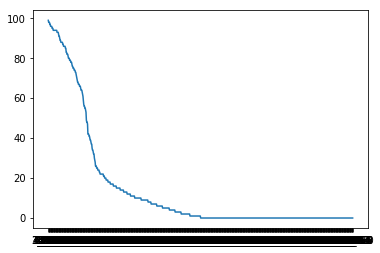

In [129]:
plt.plot(outliers_per_column[:800])

On remarque sur la figure ci-dessus que le nombre d'outliers par window décroit drastiquement sur les 200 premières windows de outliers_per_column. Nous pouvons donc supposer, selon cette vision, que les 200 premières windows sont les windows avec des anomalies. Cela représente 12% du dataset, ce qui n'est pas aberrant.

## Conclusion

Les windows anormales seraient donc, selon notre analyse,les éléments de outlier_windows. 

In [146]:
outlier_windows = outliers_per_column[:200].index
print('proportion of outliers: ', 200/len(outliers_per_column), '\n\n')
print('Outliers: \n\n', np.array(outlier_windows))

proportion of outliers:  0.12217470983506414 


Outliers: 

 ['2_3_4' '3_1_12' '3_1_1' '4_2_1' '4_3_22' '4_3_64' '1_2_8' '3_1_3'
 '3_1_18' '2_3_141' '4_3_23' '2_1_1' '1_2_142' '1_2_1' '3_1_13' '3_2_44'
 '3_1_20' '4_3_62' '1_2_7' '4_2_20' '3_1_11' '3_1_24' '3_2_51' '1_2_5'
 '3_1_19' '4_2_9' '1_2_9' '2_3_64' '2_3_144' '2_1_6' '3_1_8' '1_2_2'
 '3_1_10' '2_3_143' '4_3_20' '1_2_3' '3_1_2' '2_1_14' '3_2_50' '3_1_5'
 '3_1_6' '3_1_15' '2_3_2' '3_2_42' '4_3_63' '3_1_4' '2_2_75' '2_3_63'
 '4_2_2' '2_1_9' '3_1_7' '4_3_58' '3_2_41' '4_3_59' '2_3_62' '4_2_16'
 '3_2_49' '2_1_8' '2_3_142' '3_2_43' '1_2_143' '2_1_5' '1_2_4' '2_3_3'
 '4_2_3' '1_2_12' '4_3_61' '2_3_6' '2_3_1' '4_3_57' '4_2_5' '3_2_45'
 '2_1_13' '2_2_35' '2_3_140' '1_2_6' '2_3_5' '4_2_4' '2_1_2' '2_2_36'
 '2_3_96' '2_3_65' '1_2_10' '2_1_18' '2_1_7' '2_2_63' '4_2_21' '1_2_62'
 '2_3_95' '3_1_9' '4_2_115' '2_3_94' '2_2_76' '4_2_110' '1_2_14' '4_3_53'
 '1_1_5' '1_2_13' '4_2_18' '4_2_73' '4_3_60' '2_2_57' '3_1_21' '2_3_60'
 '2_2_64' '2_3_61' 